In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

from os import listdir
from os.path import isfile, join
import re

import pandas as pd

import utils

In [2]:
# read files from dirs
BASE_DIR = './spearmint-config'

In [3]:
def parse_run_log(path, xcols, run_id="something" ):
    with open(path) as f:
        data = []
        for l in f.readlines():
            output = float(re.findall(r"y=(.+)", l)[0])
            job_id = int(re.findall(r"job #\s*(\d+)", l)[0])
            xs = map( lambda x : float(x), re.findall(r"\((.+)\)", l)[0].split(',') )
            data.append((run_id,job_id,output,*xs))
        return pd.DataFrame(data, columns= ['job_id', 'job_run', 'y'] + xcols)
            
parse_run_log( '%s/%s/%s' % (BASE_DIR,'goldstein_price_2d/runs', '1496875564' ), ['x1','x2'], run_id='1496875564')

,job_id,job_run,y,x1,x2
0,1496875564,1,24376.000000,-2.00000,-2.00000
1,1496875564,2,600.000000,0.00000,0.00000
2,1496875564,3,315857.874716,1.99891,-2.00000
3,1496875564,4,608747.095845,-0.83127,2.00000
4,1496875564,5,18975.248260,-2.00000,-1.08106
5,1496875564,6,548310.970656,-1.99854,1.78219
6,1496875564,7,89718.645278,-1.99999,0.41809
7,1496875564,8,2676.903598,2.00000,1.14413
8,1496875564,9,181.142330,2.00000,0.42958
9,1496875564,10,1585.175353,2.00000,0.82465


In [4]:
def retrieve_runs_from_dir(dirname, xcols, runs_dir="runs"):
    dir_path = "%s/%s/%s/"  % ( BASE_DIR, dirname, runs_dir )
    data = []
    for f in listdir(dir_path):
        if not isfile(join(dir_path, f)):
            continue
        
        df = parse_run_log( '%s/%s' % (dir_path, f ), xcols, f)
        
        data.append(df)
    return data

results = retrieve_runs_from_dir('goldstein_price_2d', ['x1','x2'])

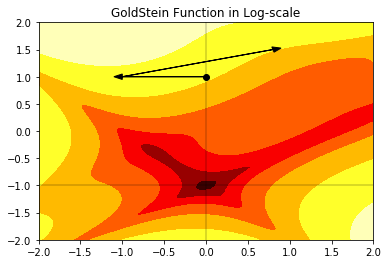

In [5]:
def plotGoldSteinEvaluation(sampling_points, title="GoldStein Function in Log-scale"):
    xx_N = 100
    lin_range = 2
    xx_lin = np.linspace(-lin_range, lin_range, xx_N)
    yy_lin = np.linspace(-lin_range, lin_range, xx_N)
    xx_g, yy_g = np.meshgrid(xx_lin, yy_lin)
    vec_goldstein = np.vectorize(utils.goldstein_price)

    z = np.log(vec_goldstein(xx_g, yy_g))

    plt.contourf(xx_g, yy_g, z, cmap='hot')

    plt.plot([0, 0], [-lin_range, lin_range], 'k-', lw=0.3)
    plt.plot([-lin_range, lin_range], [-1, -1], 'k-', lw=0.3)
    
    if len(sampling_points) > 0:
        plt.scatter(sampling_points[0,0], sampling_points[0,1], color = "k", marker = "o")

        for i in range(1,len(sampling_points)):
            prev = sampling_points[i-1]
            curr = sampling_points[i]
            plt.arrow(prev[0], prev[1], curr[0] - prev[0], curr[1] - prev[1], head_width=0.1, head_length=0.1, fc='k', ec='k')
            
    plt.title(title)
    
sampling_data = np.array([(0,1), (-1,1), (0.8,1.5)])
plotGoldSteinEvaluation(sampling_data)

# Spearmint walks on GoldStein Function

Goldstein Price Optimization from 20 Bayesian Optimization Runs in 10 steps


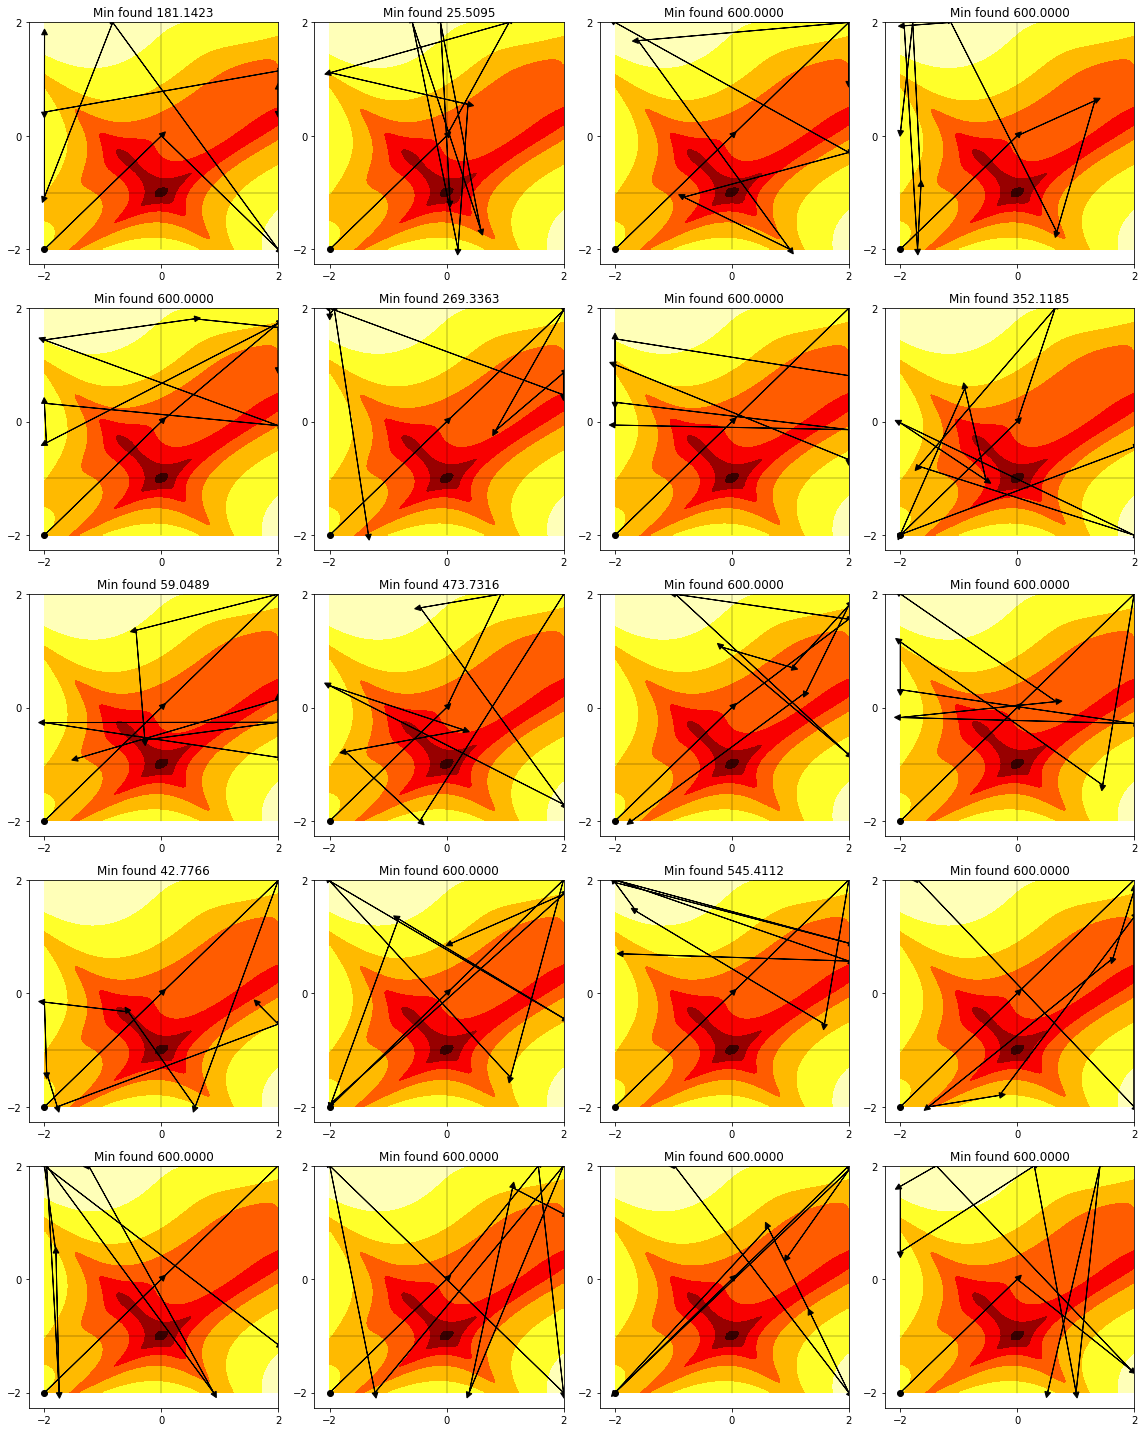

In [6]:
plt.figure(figsize=(16,20))

print('Goldstein Price Optimization from 20 Bayesian Optimization Runs in 10 steps')

for i in range(len(results)):

    df = results[i]
    data = df.as_matrix(columns=['x1','x2'])
    y_min = df.y.min()
    plt.subplot(5,4, i+1)
    title = "Min found %5.4f" % y_min
    plotGoldSteinEvaluation(data,title=title)
    plt.xticks([-2,0,2])
    plt.yticks([-2,0,2])
plt.tight_layout()

# Spearmint on GP functions

In [7]:
x_2d, a_2d, min_2d, max_2d = utils.loadData(2, 'testing')

In [8]:
print(x_2d[0].shape)
print(a_2d.shape)

(6, 2)
(2000, 6, 1)


In [9]:
DIM = 2
N_BUMPS = 6
LENGTH = 2.0/N_BUMPS*np.sqrt(DIM)

def kernel(x1,x2):
    return np.exp(-1.0/LENGTH**2*np.sum((np.expand_dims(x1,axis=2) - np.expand_dims(x2,axis=1))**2, axis = 3))


def GP(X,A,x):
    k_xX = kernel(x,X)
    return np.squeeze(np.matmul(k_xX,  A),axis=(2,))

def normalize(minv, maxv, y):
    return 2*(y-minv)/(maxv-minv)-1.0

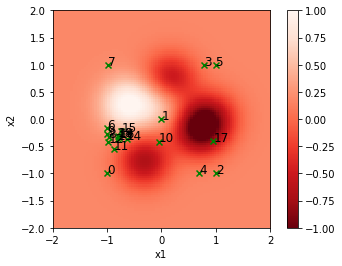

In [10]:
# Read data from config file
X_PLOT_RANGE = 100
X_PLOT_LIMIT = 2

XX1 = np.linspace(-X_PLOT_LIMIT, X_PLOT_LIMIT, X_PLOT_RANGE)
XX2 = np.linspace(-X_PLOT_LIMIT, X_PLOT_LIMIT, X_PLOT_RANGE)
XX = np.array(np.meshgrid(XX1,XX2)).T.reshape(1,-1,2)

def compute_gp_function_values(xx, data_idx=1):
    X = np.expand_dims(x_2d[data_idx], axis=0)
    A = a_2d[data_idx]
    miv = min_2d[data_idx]
    mxv = max_2d[data_idx]

    z = GP(X,A, xx).T
    f_values = normalize(miv, mxv, z)
    

    return f_values

def spearmint_sampling_points(data_idx=1):
    log_name = 'gp-%d' % data_idx
    df = parse_run_log( '%s/%s/%s' % (BASE_DIR,'gp-test/runs', log_name ), ['x1','x2'], run_id=log_name)
    sampling_points = df[['x1','x2']].as_matrix()
    return sampling_points
    
def plot_gp_function(f_values, sampling_points, colorbar=False):
    
    extend = [-X_PLOT_LIMIT,X_PLOT_LIMIT,-X_PLOT_LIMIT,X_PLOT_LIMIT]
    plt.imshow(f_values.reshape(X_PLOT_RANGE,X_PLOT_RANGE), cmap='Reds_r', interpolation='nearest', extent=extend, origin="lower", vmin=-1, vmax=1)
   
    if colorbar:
        plt.colorbar()

    plt.xlabel('x1')
    plt.ylabel('x2')
    
    plt.scatter(sampling_points[:,0], sampling_points[:,1], color = "green", marker = "x")
    for i in range(len(sampling_points)):
        curr = sampling_points[i]
        plt.text(curr[0], curr[1], str(i), fontsize=12, color="black")
    
data_idx =5
f_values = compute_gp_function_values(XX, data_idx=data_idx)
sm_x_100th = spearmint_sampling_points(data_idx=data_idx)
plot_gp_function(f_values, sm_x_100th, colorbar=True)

In [11]:
sm_x_100th.shape

(20, 2)

In [12]:
compute_gp_function_values(sm_x_100th.reshape(1,-1,2), data_idx=5)

array([[ 0.10244515],
       [ 0.37119904],
       [ 0.23262474],
       [ 0.10050766],
       [ 0.3981329 ],
       [ 0.15555581],
       [-0.43683927],
       [ 0.14097348],
       [-0.53607277],
       [-0.49031689],
       [ 0.64063659],
       [-0.4658824 ],
       [-0.4985446 ],
       [-0.66482742],
       [-0.58366057],
       [-0.62970845],
       [-0.67204664],
       [ 0.13810288],
       [-0.67045846],
       [-0.67214569]])

In [13]:
GP_TEST_INDICES = [100, 5, 90, 71, 2, 999, 33, 400, 500]

" ".join(map(str,GP_TEST_INDICES))

'100 5 90 71 2 999 33 400 500'

In [14]:
conf = utils.loadConfig()
best_model_2d = 'rnn-cell-2d-1497306764'#conf['experiments']['2D']['best_model']
best_model_2d

'rnn-cell-2d-1497306764'

In [16]:
import rnn_n2n as my_rnn
from prettytable import PrettyTable
import json

def evaluate_gp_ith_with_model(data_index,model,dim, debug=False):    
    x_2d, a_2d, min_2d, max_2d = utils.loadData(dim, 'testing')

    data_Xt = x_2d[data_index]
    data_At  = a_2d[data_index].reshape(1,-1,1)
    data_mint = min_2d[data_index].reshape(-1,1)
    data_maxt = max_2d[data_index].reshape(-1,1)

    # load trained model
    tf.reset_default_graph()
    model_path = './trained_models/%s' % model
    
    with open('%s/network-params.json' % model_path ) as jsonfile:
        model_params = json.load(jsonfile)

    keys = list(model_params.keys())   
    keys.sort()
    
    x = PrettyTable()
    x.field_names = ["Parameter", "Value"]

    for k in keys:
        x.add_row([k, model_params[k]])
        
    x.align = 'l'

    if debug:
        print(model_path)
        print('Load %s model' % model )
        print(x)

    res = None
    with tf.Session() as sess:
        params_dict = {
            'n_bumps': model_params['n_bumps'],
            'dim' : model_params['dim'],
            'n_hidden': model_params['n_hidden'],
            'forget_bias': model_params['forget_bias'],
            'n_steps': model_params['n_steps'],
            'l': model_params['gp_length'],
            'scope': model_params['scope']
        }
        
        Xt, At, mint, maxt, samples_x, samples_y = my_rnn.build_training_graph(**params_dict)
        
        saver = tf.train.Saver()
        saver.restore(sess, '%s/model' % model_path)

        feed_dict = {
            Xt: data_Xt.reshape(1,-1,dim),
            At: data_At,
            mint: data_mint,
            maxt: data_maxt
        }

        res = sess.run(samples_y, feed_dict=feed_dict)
        x_values = sess.run(samples_x, feed_dict=feed_dict)
    return np.array(res).flatten(), np.array(x_values).flatten().reshape(-1,dim)
lstm_eval_gp_400th, lstm_x_gp_400th = evaluate_gp_ith_with_model(400, "rnn-cell-2d-1497305620", dim=2, debug=True)
lstm_eval_gp_400th

./trained_models/rnn-cell-2d-1497305620
Load rnn-cell-2d-1497305620 model
+---------------------+------------------------+
| Parameter           | Value                  |
+---------------------+------------------------+
| dim                 | 2                      |
| epochs              | 600                    |
| forget_bias         | 5.0                    |
| gp_length           | 0.4714045207910317     |
| learning_rate_final | 0.0001                 |
| learning_rate_init  | 0.005                  |
| loss_function       | MIN                    |
| n_bumps             | 6                      |
| n_hidden            | 10                     |
| n_steps             | 20                     |
| scope               | rnn-cell-2d-1497305620 |
+---------------------+------------------------+
INFO:tensorflow:Restoring parameters from ./trained_models/rnn-cell-2d-1497305620/model


array([ 0.09278786, -0.2889967 , -0.30570394, -0.22950673, -0.251836  ,
       -0.46449232, -0.48881108, -0.23187065, -0.29844129, -0.05461329,
        0.21791446,  0.24965131,  0.52393746,  0.9738524 ,  0.55768967,
        0.20712805,  0.37383509,  0.38665986,  0.35267401,  0.27298248,
        0.23511064], dtype=float32)

In [17]:
lstm_x_gp_400th

array([[-0.        , -0.        ],
       [ 0.09605701,  0.41419572],
       [ 0.18692186,  0.23769556],
       [ 0.31632763,  0.01692637],
       [ 0.5734489 , -0.23449193],
       [ 0.78817832, -0.26437917],
       [ 0.8351987 , -0.06159202],
       [ 0.721816  ,  0.27873009],
       [ 0.3626858 ,  0.65694857],
       [-0.0499515 ,  0.7462402 ],
       [-0.38708603,  0.47363144],
       [-0.25081545, -0.19430581],
       [ 0.50039208, -0.65055352],
       [ 0.68590707, -0.83925235],
       [ 0.42170009, -0.83670682],
       [-0.25819811, -0.80909103],
       [-0.69116718, -0.71973383],
       [-0.88856798, -0.2371491 ],
       [-0.90850353,  0.59753162],
       [-0.7901389 ,  0.91021883],
       [-0.72401863,  0.95227081]], dtype=float32)

INFO:tensorflow:Restoring parameters from ./trained_models/rnn-cell-2d-1497306764/model


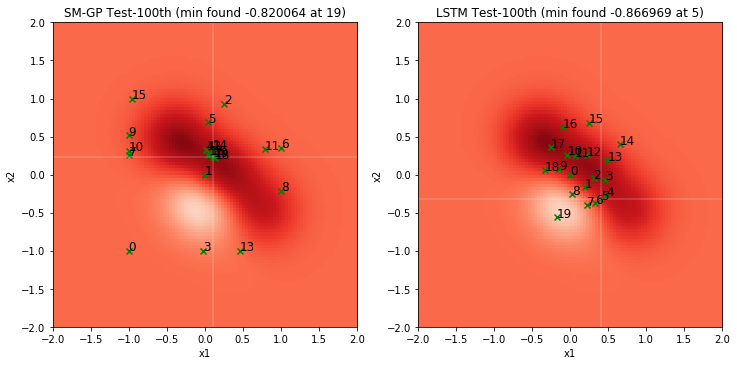

In [18]:
def plot_line_mark(x1,y1):
    plt.plot([x1, x1], [-X_PLOT_LIMIT, X_PLOT_LIMIT], 'w-', lw=0.3)
    plt.plot([-X_PLOT_LIMIT, X_PLOT_LIMIT], [y1,y1] , 'w-', lw=0.3)
    
def plot_comparison2d_on_gp(data_idx):
    plt.figure(figsize=(12,6))
    # for i in range(len(GP_TEST_INDICES)):
    # plot spearmint
    plt.subplot(1,2,1)    
    f_values = compute_gp_function_values(XX, data_idx=data_idx)
    
    sm_x_100th = spearmint_sampling_points(data_idx=data_idx)
    sm_f_values = compute_gp_function_values(sm_x_100th.reshape(1,-1,2), data_idx=data_idx)
    min_sm = np.argmin(sm_f_values)
    plot_gp_function(f_values, sm_x_100th)

    plt.title('SM-GP Test-%dth (min found %f at %d)' % (data_idx, sm_f_values[min_sm], min_sm) )
    plot_line_mark(*sm_x_100th[min_sm, :])
    
    # plot lstm
    plt.subplot(1,2,2)    
    f_values = compute_gp_function_values(XX, data_idx=data_idx)

    lstm_f_values, lstm_x_400 = evaluate_gp_ith_with_model(data_idx, best_model_2d, dim=2)
    
    
    min_lstm = np.argmin(lstm_f_values[:-1])

    plot_gp_function(f_values, lstm_x_400[:-1,:])
    plt.title('LSTM Test-%dth (min found %f at %d)' % (data_idx, lstm_f_values[min_lstm], min_lstm) )
    plot_line_mark(*lstm_x_400[min_lstm, :])
plot_comparison2d_on_gp(GP_TEST_INDICES[0])

In [ ]:
for i in GP_TEST_INDICES:
    plot_comparison2d_on_gp(i)
    plt.savefig('./images-temp/comparision-gp-test-%dth.png' % i)

In [19]:
def evaluate_gp_at_point(data_idx, x1,x2):
    X = np.expand_dims(x_2d[data_idx], axis=0)
    A = a_2d[data_idx]
    miv = min_2d[data_idx]
    mxv = max_2d[data_idx]
    
    xx = np.array([x1,x2]).reshape(1,1,2);

    z = GP(X,A, xx).T
    z_norm = normalize(miv, mxv, z)
    return z_norm
evaluate_gp_at_point(71, -1,-1)

array([[ 0.12905712]])

In [20]:
GP_TEST_INDEX = 400
def plot_gp_min_found():
    evaluation_steps = range(0,20)
    y = np.log(-np.arange(0,5,20))

In [ ]:
parse_run_log( '%s/%s/%s' % (BASE_DIR,'gp-test/runs', 'gp-71' ), ['x1','x2'], run_id='gp-71')

In [ ]:
results_gp_400th = retrieve_runs_from_dir('gp-test-ith', ['x1','x2'], runs_dir='runs-400-th')

In [ ]:
len(results_gp_400th)

In [ ]:
import unittest
tc = unittest.TestCase('__init__')

def min_up_to_k(data):
    total = len(data)
    mins_up_to_k = [data[0]]
    
    for k in range(1, total):
        m = mins_up_to_k[k-1]
        if mins_up_to_k[k-1] > data[k]:
            m = data[k]
        mins_up_to_k.append(m)
        
    return mins_up_to_k

tc.assertEqual(min_up_to_k([1,3,0.5,2,8,3,4]),[1,1,0.5,0.5,0.5,0.5,0.5])

In [ ]:
def plot_min_across_runs(data, color="blue") :
    mins_across_runs = []
    total = len(data)
    for  i in range(total):
        df = data[i]
        mins = min_up_to_k(df.y.as_matrix())
        mins_across_runs.append(mins)
        
    # mins_across_runs.shape = run*step
    # aka each step is each column
    mins_across_runs = np.vstack(mins_across_runs)
    
    mean_mins = np.mean(mins_across_runs, axis=0)
    std_mins = np.std(mins_across_runs, axis=0)

    total_means = len(mean_mins)
    x_lins = range(0, total_means)
    plt.plot(x_lins, mean_mins, color = color, label="Spearmint %d runs" % total)
    up = mean_mins + 2*std_mins
    lo = mean_mins - 2*std_mins
    plt.fill_between(x_lins, lo, up, facecolor=color, interpolate=True, alpha=0.1)

    lstm_eval_gp_400th, _ = evaluate_gp_ith_with_model(400, best_model_2d, dim=2)
    lstm_min_at_k = min_up_to_k(lstm_eval_gp_400th[:total_means])
    plt.plot(x_lins, lstm_min_at_k, color = "red", label="LSTM")

    plt.xticks(np.arange(0, len(mean_mins),2))
    plt.xlabel('Evaluation Step')
    plt.ylabel('Min Found')
    plt.legend()

plt.title("GP-400th")
plot_min_across_runs(results_gp_400th)

# LTSM Loss Function Comparison

In [ ]:
def comparision_of_loss_functions(models, data_index=300):
    f_values = compute_gp_function_values(XX, data_idx=data_idx)
    
    plt.figure(figsize=(15,25))

    keys = list(models.keys())
    keys.sort()
    count = 1
    for k in keys:
        m = models[k]
        lstm_f_values, lstm_x_400 = evaluate_gp_ith_with_model(data_index, m, dim=2)
        min_lstm = np.argmin(lstm_f_values[:-1])
        plt.subplot(3,2,count)
        plot_gp_function(f_values, lstm_x_400[:-1,:])
        plt.title('LSTM Loss %s' % k )
        plot_line_mark(*lstm_x_400[min_lstm, :])
        count = count + 1


models = {
 'MIN': 'rnn-cell-2d-1497306764', # loss : min
 'SUM': 'rnn-cell-2d-1497308299', # loss : sum
 'SUMMIN': 'rnn-cell-2d-1497313100', # loss : summin
 'WSUM': 'rnn-cell-2d-1497309842', # loss : wsum
 'WSUM_EXPO': 'rnn-cell-2d-1497314598' # loss : wsum_expo
}

comparision_of_loss_functions(models)

## END

In [ ]:
b = re.findall(r"y=(.+)", 'job #10 : (2.00000,0.82465)	->	y=1585.175353')
print(b)

In [ ]:
 for i in range(20):
    print(results[i].y.min())

In [ ]:
len(results)

In [ ]:
a = True

In [ ]:
with a as a:
    print(55)

In [ ]:
%%
 For L_{OI}, a min(. , 0) is missing. The correct form should be
E_{f, y_{1:T-1} [ \sum_{t=1}^T \min{f(x_t) - min_{i<t} (f(x_i)), 0}]
and for every time step t, I compute the gradient wrt f(x_t) and treat the term f(x_i) as constant.
- To encourage the network to output x_t in the region of [0, 1]^d, I add an extra loss of 
10 * L1_distance_to_[0,1]^d. That is, if the output is outside the valid region, as a linear loss proportional to its L1 distance to the region boundary.

%%

In [ ]:
def abc(x,y):
    return x*y
abc(2,3)

vectorized_abc = np.vectorize(abc)
vectorized_abc(np.array([1,2]), np.array([2,4]))